# Machine Learning Models

## Clustering

In [1]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn import preprocessing 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('/home/tom/Documents/ParlayPlay/Data/Retention Data V1 - Raw.csv')

### Cleaning the Data

In [4]:
# remove na
df.dropna(how='all')

,id,customer_id,is_ftd,is_limited,dob,age,coupon_designation,created_est,sign_up_time,total_amount,...,average_entry_amount,average_nr_of_picks,GGR,deposit_amount,withdrawal_amount,net_cash,First SP Result,Most Frequent State,First deposit amount,First Deposit Date
0,154,efa2a6aa-7082-473b-8942-2500f402d2ce,True,False,2000-05-04,23,referral,2021-05-01 18:21:53,evening,500,...,10.00,2.78,216.0,130,0.0,130.0,won,Texas,10.0,2021-05-09 16:19:45.718955+00
1,243,4095176d-5467-4b61-a5e9-d9afc8c8cd63,True,False,2000-10-06,23,referral,2021-05-07 14:59:44,afternoon,551,...,14.13,3.05,-260.0,80,-380.0,-300.0,cancelled,Texas,20.0,2021-09-13 22:33:24.320015+00
2,264,a12b6b2f-d824-41f2-9319-83519c2a9bf7,True,False,2002-11-11,21,referral,2021-05-07 16:15:23,afternoon,725,...,5.00,2.93,-589.0,140,-739.0,-599.0,lost,Texas,20.0,2021-05-23 15:05:02.886358+00
3,430,1784434e-ad74-47ed-8cc9-560cafac78b1,True,False,1952-10-05,71,referral,2021-05-09 18:56:40,evening,13,...,6.50,2.50,13.0,10,0.0,10.0,lost,Texas,10.0,2022-09-03 02:00:08.787973+00
4,505,a877a382-f961-40f7-8487-790ddf3e16ff,True,False,1995-01-01,28,referral,2021-05-21 14:13:12,afternoon,117,...,10.64,2.73,-8.0,25,0.0,25.0,won,Massachusetts,25.0,2021-12-23 23:44:39.796742+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73465,27639,32ed11e0-bed1-40ca-bf0d-a9d5a499c7f5,True,False,1993-04-08,30,Offline,2022-09-03 12:00:27,afternoon,0,...,0.00,0.00,0.0,25,0.0,25.0,NaN,NaN,25.0,2022-09-03 17:05:14.538545+00
73466,28680,69e1b991-2ade-4629-a895-16cd45650cd1,True,False,1994-08-14,29,Offline,2022-09-15 20:42:47,evening,0,...,0.00,0.00,0.0,25,0.0,25.0,NaN,NaN,25.0,2022-09-16 01:50:30.005545+00
73467,167286,bbfac639-f8c1-47ce-a2b3-57e9e88a3bfa,True,False,1995-06-28,28,Influencer,2023-07-20 18:51:53,evening,0,...,0.00,0.00,0.0,25,0.0,25.0,NaN,NaN,25.0,2023-07-20 23:52:19.899384+00
73468,86833,b96b3f5e-0dc0-494e-bba8-151d44671507,True,False,1962-03-10,61,Paid Digital,2023-02-12 16:15:22,afternoon,0,...,0.00,0.00,0.0,0,0.0,0.0,NaN,NaN,0.0,NaN


In [5]:
# Remove Outliers

numerical_cols = ['age','total_amount','contest_count', 'average_entry_amount', 'average_nr_of_picks','GGR','deposit_amount', 'withdrawal_amount', 'net_cash', 'First deposit amount']
df[numerical_cols] = df[numerical_cols].mask(np.abs(stats.zscore(df[numerical_cols])) >= 3)
df = df.dropna(axis = 0)

df['coupon_designation'] = df['coupon_designation'].replace('influencer', 'Influencer')

df['created_est'] = pd.to_datetime(df['created_est'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)
df['First Deposit Date'] = pd.to_datetime(df['First Deposit Date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)

In [6]:
# placing data into bins
df['age_bin'] = pd.cut(df['age'], np.arange(0, 100, 10))


max_c_c = df['contest_count'].max()
min_c_c = df['contest_count'].min()

df['contest_count_bin'] = pd.cut(df['contest_count'], np.arange(min_c_c, max_c_c, 10),include_lowest=True)

In [7]:
pd.set_option('display.max_columns', 100)

## Data Preprocessing

In [8]:
# add time_diff
df['time_diff'] = (df['First Deposit Date'] - df['created_est']).astype('timedelta64[h]')

In [9]:
def create_ohe(x):
    
    label_dict = {}
    
    for label in x.unique():
        
        if label not in label_dict:
            label_dict[label] = len(label_dict)
    
    
    ohe = np.zeros((len(df), len(x.unique())))
    for i, row in enumerate(x):
        ohe[i, label_dict[row]] = 1
    return pd.DataFrame(ohe)

In [10]:
labelled_cols = ['is_ftd', 'is_limited', 'coupon_designation', 
                'sign_up_time', 'First SP Result', 'Most Frequent State',
               'age_bin', 'contest_count_bin']

    

for col in labelled_cols:
    df = pd.concat([df.reset_index(drop=True),create_ohe(df[col]).reset_index(drop=True)], axis=1)

In [11]:
# remove non_numerical columns

remove_cols = ['id', 'customer_id', 'dob', 'created_est', 'First Deposit Date']
remove_cols.extend(labelled_cols)

df.drop(remove_cols, axis = 1, inplace = True)
df_raw_data = df.copy()
print(df_raw_data.columns)
df.head()

Index([                 'age',         'total_amount',        'contest_count',
       'average_entry_amount',  'average_nr_of_picks',                  'GGR',
             'deposit_amount',    'withdrawal_amount',             'net_cash',
       'First deposit amount',
       ...
                           26,                     27,                     28,
                           29,                     30,                     31,
                           32,                     33,                     34,
                           35],
      dtype='object', length=112)


,age,total_amount,contest_count,average_entry_amount,average_nr_of_picks,GGR,deposit_amount,withdrawal_amount,net_cash,First deposit amount,time_diff,0,0,1,0,1,2,3,4,5,6,7,8,0,1,2,3,0,1,2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,32,33,34,35,36,37,38,39,40,0,1,2,3,4,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,23.0,500.0,50.0,10.00,2.78,216.0,130.0,0.0,130.0,10.0,189.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23.0,551.0,39.0,14.13,3.05,-260.0,80.0,-380.0,-300.0,20.0,3103.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21.0,725.0,145.0,5.00,2.93,-589.0,140.0,-739.0,-599.0,20.0,382.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28.0,117.0,11.0,10.64,2.73,-8.0,25.0,0.0,25.0,25.0,5193.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24.0,392.0,44.0,8.91,2.30,17.0,10.0,-85.0,-75.0,10.0,1298.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Normalise Columns that need it
df_cols = df.columns
df.columns = pd.RangeIndex(df.columns.size)

def normalise(column):
    return ((column - column.mean())/column.std())

for col in df.columns:
    df[col].update(normalise(df[col])) 
    

In [13]:
# reduce dimensionality

pca = PCA(n_components=2)
pca.fit(df)
df_pca_2 = pca.transform(df)

## Clustering

For 1 Clusters
For 2 Clusters
For 3 Clusters
For 4 Clusters
For 5 Clusters
For 6 Clusters
For 7 Clusters
For 8 Clusters
For 9 Clusters
For 10 Clusters


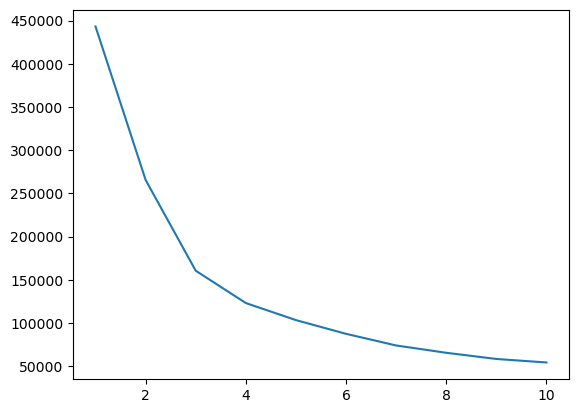

In [14]:
# we want to find the best number of clusters

cluster_inertias = []

for i in range(1,11):
    print("For {} Clusters".format(i))
    kmeans = KMeans(n_clusters=i, random_state=0, n_init = 10) 
    kmeans.fit(df_pca_2)
    cluster_inertias.append(kmeans.inertia_)

plt.plot(range(1,11), cluster_inertias)
plt.show()


In [15]:
# so we see that the ideal number of clusters is around 6

final_kmeans = KMeans(n_clusters=6, random_state=0, n_init = 10) 
final_kmeans.fit(df_pca_2)

df_pca_2_labelled = pd.DataFrame(df_pca_2)
df_pca_2_labelled['Label'] = final_kmeans.predict(df_pca_2)

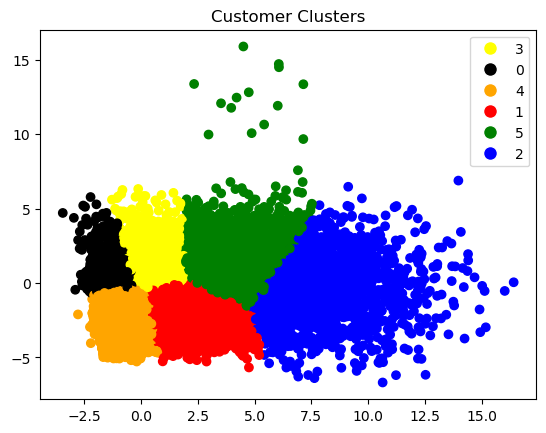

In [16]:
# create colour palette
colours = ['blue', 'green', 'red', 'orange', 'black', 'yellow']

label_colours = {}

for label in list(df_pca_2_labelled['Label'].unique()):
    if label not in colours: 
        label_colours[label] = colours.pop()

        
plt.scatter(df_pca_2_labelled[0], df_pca_2_labelled[1], c = df_pca_2_labelled['Label'].map(label_colours))

legend_labels = label_colours.keys()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                             markerfacecolor=label_colours[label], markersize=10) for label in legend_labels]

plt.legend(handles=legend_handles, labels=legend_labels)
plt.title("Customer Clusters")
plt.show()

In [20]:
# Analysis of each group

non_ohe_cols = [i for i in df_raw_data.columns if not isinstance(i, int)]

df_raw_data['Label'] = df_pca_2_labelled['Label']

cluster_data_dict = {}

for label in list(df_raw_data['Label'].unique()):
    each_cluster_dict = {}
    print("\nCluster {}".format(label))
    df_per_cluster = df_raw_data[df_raw_data['Label'] == label]   
    for col in non_ohe_cols:
        col_mean = df_per_cluster[col].mean()
        print("{}: {}".format(col, col_mean))
        each_cluster_dict[col] = col_mean
    
    cluster_data_dict[label] = each_cluster_dict
    



Cluster 3
age: 24.766511352710598
total_amount: 367.25826492123366
contest_count: 36.6163745285112
average_entry_amount: 13.31268249389838
average_nr_of_picks: 3.9126950669329195
GGR: 71.24871902965758
deposit_amount: 121.37526810147179
withdrawal_amount: -101.46816063900599
net_cash: 19.907107462465795
First deposit amount: 50.91043561866726
time_diff: 423.50477035722207
Label: 3.0

Cluster 0
age: 23.714968020599716
total_amount: 99.51457762272614
contest_count: 9.863817592823324
average_entry_amount: 12.200281169532353
average_nr_of_picks: 3.1381157072846575
GGR: 29.82227967439156
deposit_amount: 33.13481186145029
withdrawal_amount: -31.95928108646898
net_cash: 1.1755307749813106
First deposit amount: 23.59851316554531
time_diff: 449.8162638092865
Label: 0.0

Cluster 4
age: 39.48619199699418
total_amount: 118.10802179222243
contest_count: 11.572797294758594
average_entry_amount: 13.055165007201452
average_nr_of_picks: 3.295129313044023
GGR: 54.82675245788715
deposit_amount: 42.78852

## Initial Insights

On the scatter graph, we see that the closer a user is to the (0,0), the less they engage with the platform. 

There appears to be 2 clusters of younger users: those who actively engage with the platform (Cluster 3) and those that don't (Cluster 0). This is shown by the contest count (37 vs 10) and net_cash (20 vs 1). It also shows that maybe some fields aren't as relevant for this age range (average entry amount and average number of picks are very similar).

There's also 2 clusters of older users (Cluster 4 and 1), with 1 containing the engaged users (higher contest count and net cash compared with 4). 

Then in between there are 2 very active clusters (5, 2) with 2 being slightly more active and older. Potentially we could be seeing Cluster 5 turning into Cluster 2 as they stay with the platform. 